In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# TODO

In [3]:
import glob

In [4]:
import os
os.chdir('../')

In [19]:
path = '/Users/17518516/Documents/results_lag_8'
path_tss = '/Users/17518516/Documents/results_lag_8_tss'

In [20]:
report_path = os.path.join(path, 'report')
fi_path = os.path.join(report_path, 'feature_importances')
cv_path = os.path.join(path, 'cv_results')
history_path = os.path.join(path, 'history')

report_path_tss = os.path.join(path_tss, 'report')
fi_path_tss = os.path.join(report_path_tss, 'feature_importances')
cv_path_tss = os.path.join(path_tss, 'cv_results')
history_path_tss = os.path.join(path_tss, 'history')

In [21]:
import re

def create_path_dict(path, key_regexp, extension='.csv'):
    
    def _get_key(x):
        string = x.split('/')[-1].split('.')[0]
        
        return re.search(key_regexp, string).groups()[0]
    
    files = glob.glob(os.path.join(path, f'*{extension}'))
    
    return dict(map(lambda x: (_get_key(x), x), files))

def process_report(report, mode=0):
    report = report.copy()
    report.columns = report.columns.str.extract('run_(.+)_f1', expand=False)
    report = report.sort_index(axis=1).T
    if mode == 0:
        cv = report.index[report.index.str.contains('cv_')]
        report = pd.concat([
            report.loc[cv], 
            report.drop(cv.values.tolist() + ['columnestimator'], errors=False), 
            report.loc[['columnestimator']]])
    else:
        return report
    return report

def map_color(x):
    
    codes = {
        'b': "#388BEE",
        'g': '#1DA22D',
        'r': '#D48282'
    }

    def _map(x):
        if x == 'columnestimator':
            return codes['g']
        if x == 'dummy':
            return codes['b']
        else:
            return codes['b']
    colors = list(map(_map, x.index))
    argmax = x.values.argmax()
    if colors[argmax] != codes['g']:
        colors[argmax] = codes['r']
    
    return colors

def draw_scores(ax, scores, min_score, score_font):
    for i, score in enumerate(scores):
        ax.text(
            x=max(score / 1.5, min_score), y=i - .1, s=f'{100 * score:.1f}',
            fontdict=score_font
        )
        
def plot_report(
    report, min_x=.25, max_x=.75, labelsize=14,
    score_font={'size': 14}):

    f, ax = plt.subplots(nrows=1, ncols=report.shape[1], sharey=True)
    min_x = .25


    for i in report.columns:
        colors = map_color(report[i])
        report[i].plot.barh(ax=ax[i], color=colors)
        ax[i].axvline(report[i]['columnestimator'], color='g', ls='--')
        ax[i].set_xlim(min_x, max_x)
        ax[i].grid()
        ax[i].set_title(f'Горизонт {i + 1}')
        draw_scores(ax[i], (report[i].values).tolist(), min_x + .02, score_font)

    f.set_figheight(len(report) * .6)
    f.set_figwidth(report.shape[1] * 2)
    ax[0].tick_params(axis='y', which='major', labelsize=labelsize)
    plt.tight_layout()
    
    return f, ax

def plot_fi(
    model, min_x=0, max_x=100, labelsize=14, score_font={'size': 14}):
    report = pd.read_excel(fi_dict[model], index_col=0)
    if 'catboost' in model or 'lightgbm' in model:
        report = report.divide(report.sum())
    f, ax = plt.subplots(nrows=1, ncols=report.shape[1], sharey=True)

    for i in report.columns:
        colors = map_color(report[i])
        report[i].plot.barh(ax=ax[i], color=colors)
        ax[i].set_xlim(min_x, max_x)
        ax[i].grid()
        ax[i].set_title(f'Горизонт {i + 1}')
        draw_scores(ax[i], (report[i].values).tolist(), min_x + .02, score_font)

    f.set_figheight(len(report) * .6)
    f.set_figwidth(report.shape[1] * 2)
    ax[0].tick_params(axis='y', which='major', labelsize=labelsize)
    plt.tight_layout()
    
    return f, ax

def plot_cv(name, cv_path_dict, prefix='', y_min=0.32, y_max=.5, ):

    cv = pd.read_csv(cv_path_dict[name], index_col=0)
    name = prefix + name
        
    cols = list(cv.columns[:-2])
    mean = cv.groupby(cols, dropna=False).score.mean()
    std = 3 * cv.groupby(list(cv.columns[:-2]), dropna=False).score.sem()
    
    index = list(map(str, mean.index.tolist()))
    mean.index = index
    std.index = index
    idxmax = mean.idxmax()
    plt.errorbar(
        mean.index, mean, yerr=std, capsize=4, ls='', 
        marker='x', label='Кросс-вал')
    
    plt.scatter([idxmax], [mean[idxmax]], marker='o', color='red', label='Лучшая модель')
    plt.ylim(y_min, y_max)

    plt.axhline(report.loc[name, 0], color='green', ls='--', label='$F_1$ тест')
    
    plt.xticks(rotation=90)
    
    plt.xlabel(cols)
    
    plt.legend()
    
    plt.grid()
    
def plot_history(model, n=8, x=2, x_min=0, x_max = 16, size_x=6, size_y=4):
    y = n // x + ((n / x - n // x) > 0)
    f, ax = plt.subplots(ncols=x, nrows=y,)
    for i in range(8):
        (
            pd.read_csv(history_dict[f'{model}_{i}'], index_col=0,)
              .plot(ax=ax[i // x][i % x]))
        ax[i // x][i % x].grid()
        ax[i // x][i % x].set_xlim(x_min, x_max)
        ax[i // x][i % x].set_title(f'Горизонт {i + 1}')

    f.set_figwidth(x * size_x)
    f.set_figheight(y * size_y)
    
    return f, ax

# Общий отчет о качестве работы моделей

Для тестирования использовались последние два года

Метрика качества - усредненное по 3-м классам $F_1$

Кросс-валидация:

1) CV - K-Fold стратифицированная кросс-валидация, K=10

2) TSS_CV - K-Fold Time Series кросс-валидация, K=10


Для части моделей использован SMOTE для увеличения количества примеров классов-меньшинств

Значения параметров моделей без префиксов CV и TSS_CV брались из коробки (значения по умолчания в пакете)

In [60]:
report = (
    pd.read_excel(os.path.join(report_path, 'report.xlsx'), index_col=0)
    .pipe(process_report, mode=0))
report1 = (
    pd.read_excel(os.path.join(report_path_tss, 'report.xlsx'), index_col=0)
    .pipe(process_report, mode=1))
report1.index = 'tss_' + report1.index

report = pd.concat([report1, report])

In [61]:
sorted(os.listdir('/Users/17518516/Documents/results_lag_8/report'))

['feature_importances', 'report.xlsx']

## Выводы

1) В целом качество работы моделей ухудшилось с увеличением погружения

2) На горизонте 2 лучшие результаты продемонстрировала LSTM

Архитектура LSTM

1 реккурентный слой (16 нейронов), полносвязная сеть (32, 16)

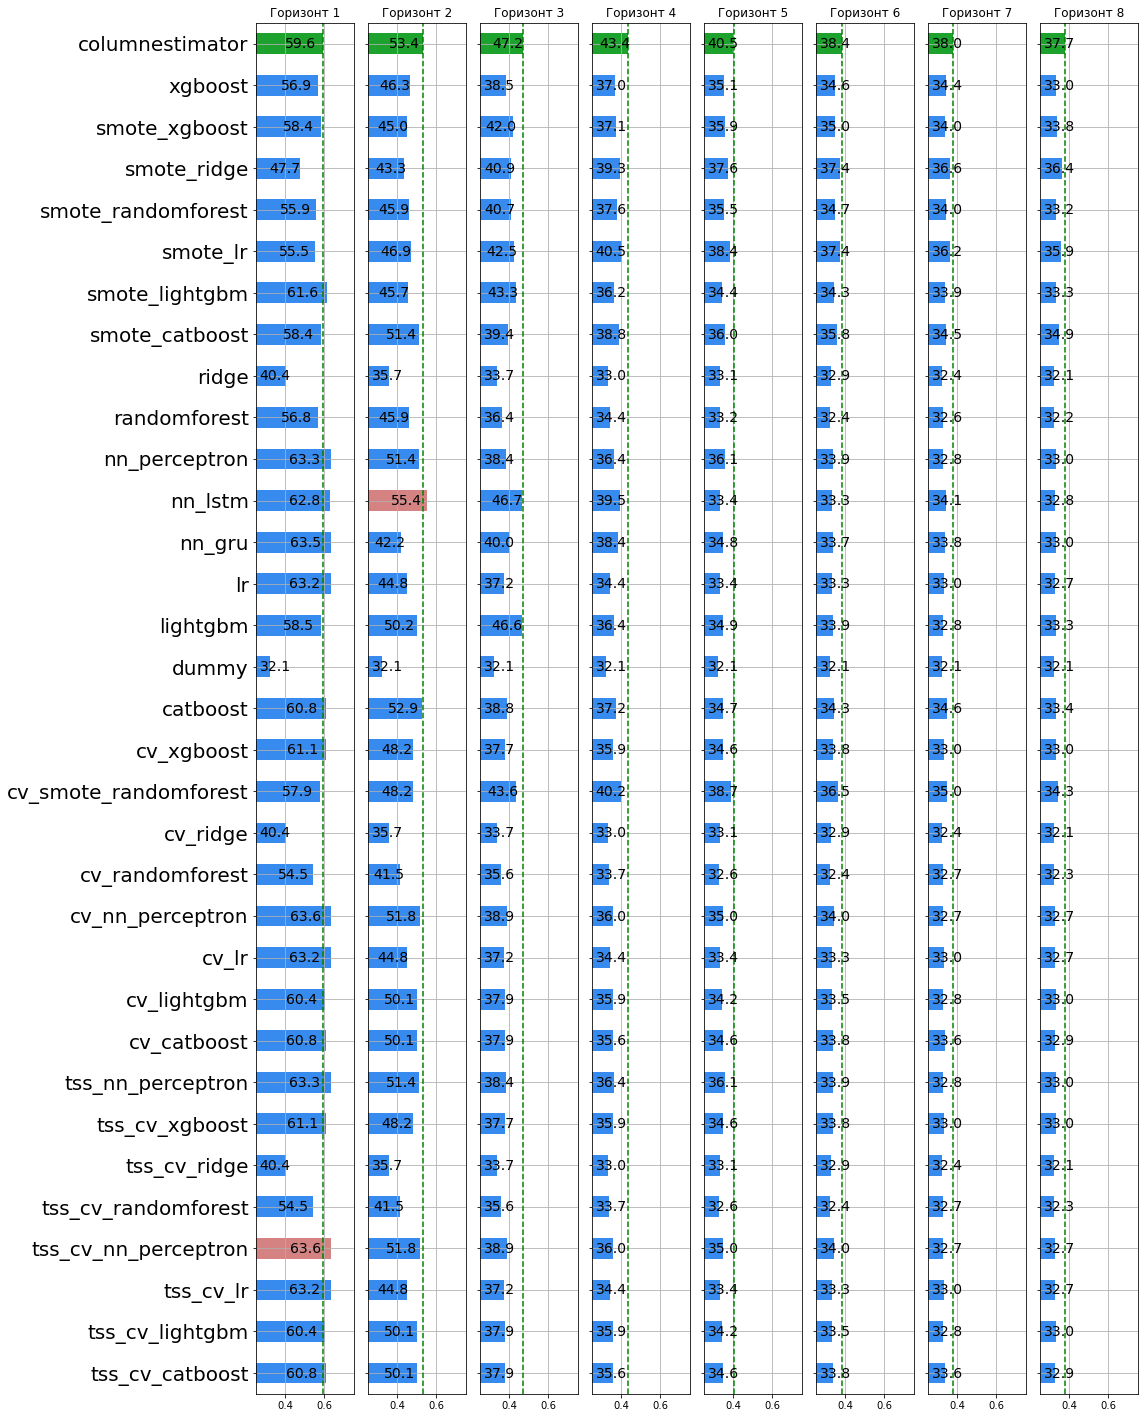

In [62]:
f, ax = plot_report(report, labelsize=20)

## Сравнение моделей бустинга

1) Catboost работает лучше всех остальных, при этом дает хороший выигрыш по скорости

2) SMOTE позволяет немного улучшить результаты, в случае, если модель работает плохо (LightGBM горизонты 2-3, XGBoost 3)

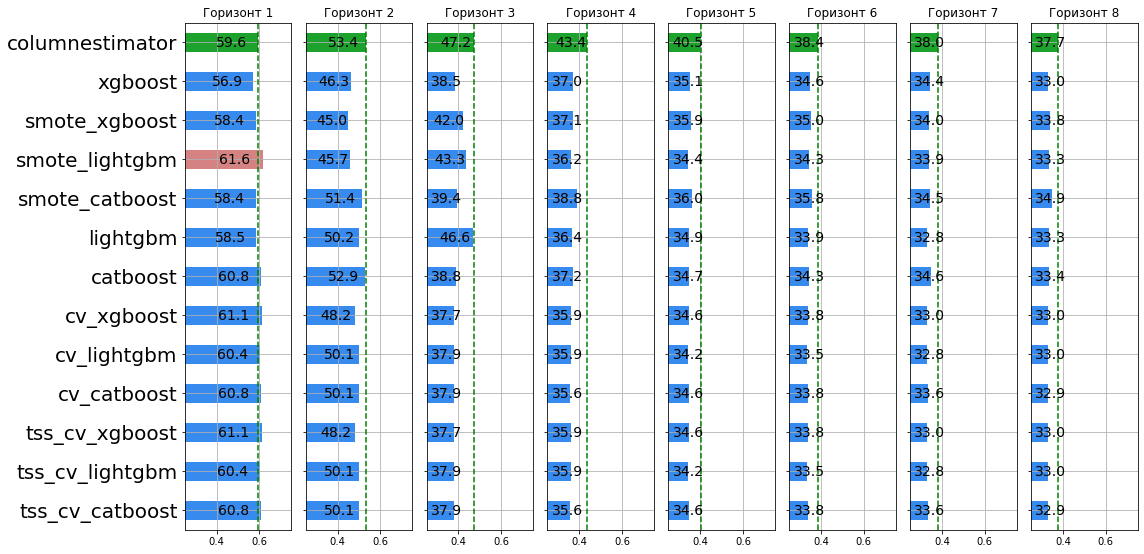

In [63]:
boosting_report = report[report.index.str.contains('boost|lightgbm|column')]

f, ax = plot_report(boosting_report, labelsize=20)

# Стратифицированная K-Fold кросс-валидация

## Выводы:

1) Стратифицированная K-Fold кросс-валидация не работает

2) Выбор параметров для бустинга кажется почти случайным

3) Time-series кросс-валидация дает адекватную оценку интервала $F_1$, однако не дает выделить самую лучшую на тесте модель

    3.1) Возможно следует использовать Time-Series кросс-валидацию с ограниченным валидационным набором. Просмотр значений $F_1$ дает понять, что выбранная на кросс-валидации модель работает лучше, в случае если тренировочный набор мал, а тестовый набор большой
    3.2) Рассмотреть вариант использования большего тестового набора для репрезентативности

## K-Fold стратифицированная кросс-валидация

In [64]:
cv_path_dict = create_path_dict(cv_path, 'run_(.+)_cv_results')

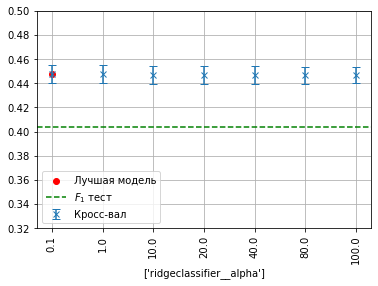

In [65]:
plot_cv('cv_ridge', cv_path_dict)

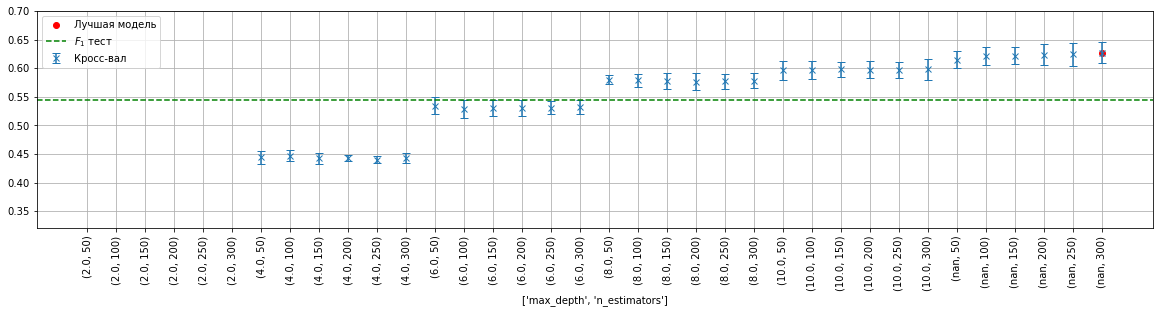

In [66]:
plt.figure(figsize=(20, 4))

plot_cv('cv_randomforest',cv_path_dict, y_max=.7)

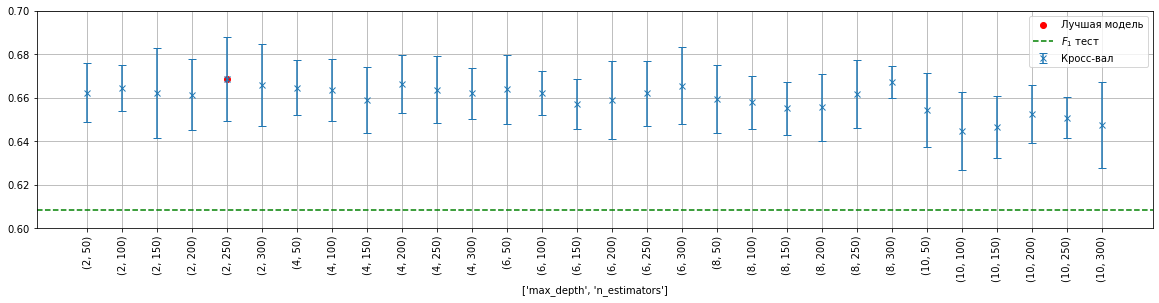

In [67]:
plt.figure(figsize=(20, 4))

plot_cv('cv_catboost', cv_path_dict, y_min=.60, y_max=.7)

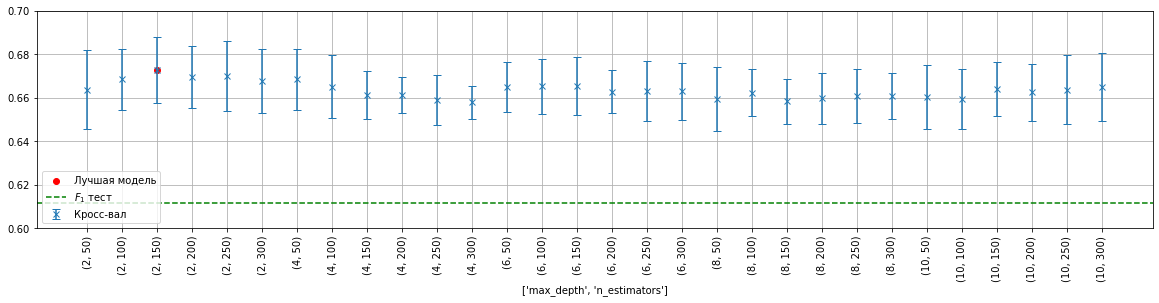

In [68]:
plt.figure(figsize=(20, 4))

plot_cv('cv_xgboost', cv_path_dict, y_min=.6, y_max=.7)

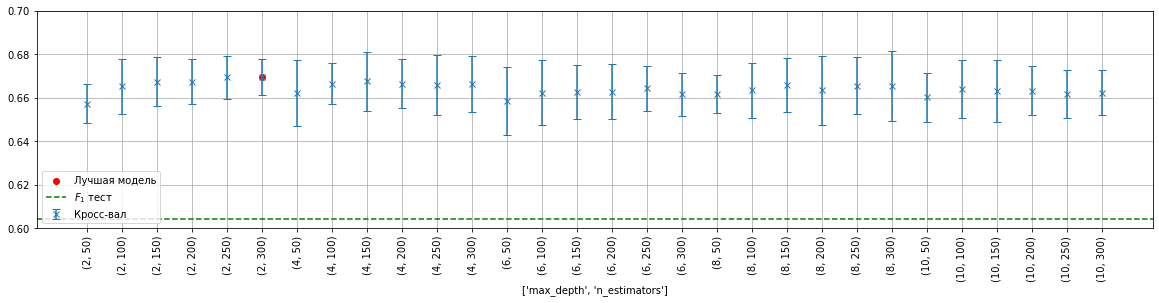

In [69]:
plt.figure(figsize=(20, 4))

plot_cv('cv_lightgbm', cv_path_dict, y_min=.6, y_max=.7)

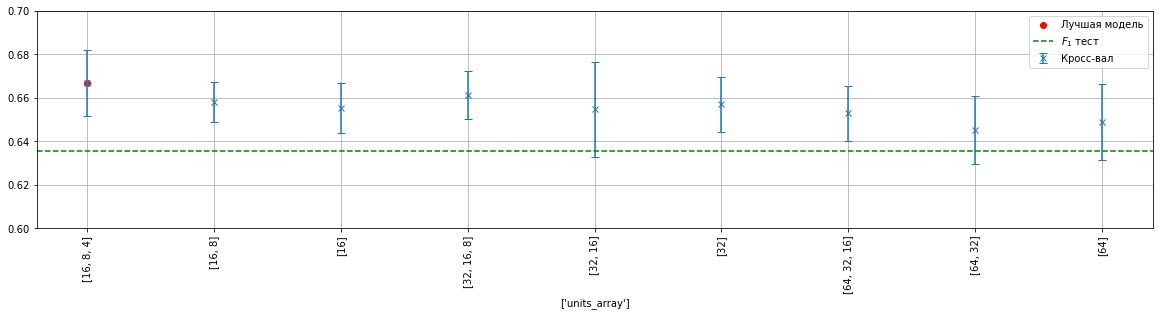

In [70]:
plt.figure(figsize=(20, 4))

plot_cv('cv_nn_perceptron', cv_path_dict, y_min=.6, y_max=.7)

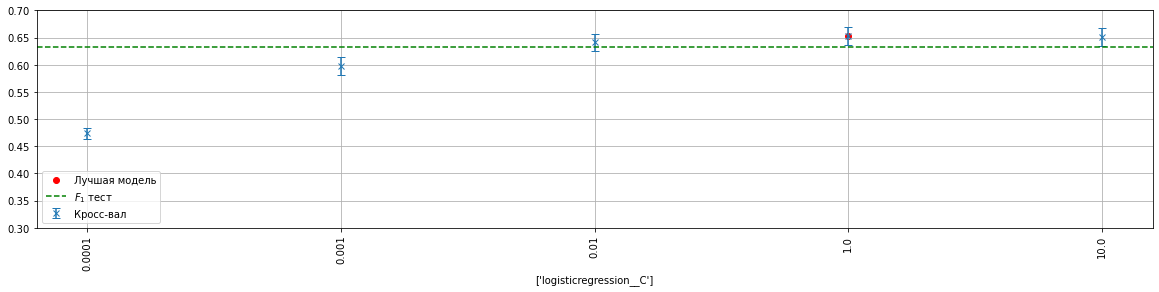

In [71]:
plt.figure(figsize=(20, 4))

plot_cv('cv_lr', cv_path_dict, y_min=.3, y_max=.7)

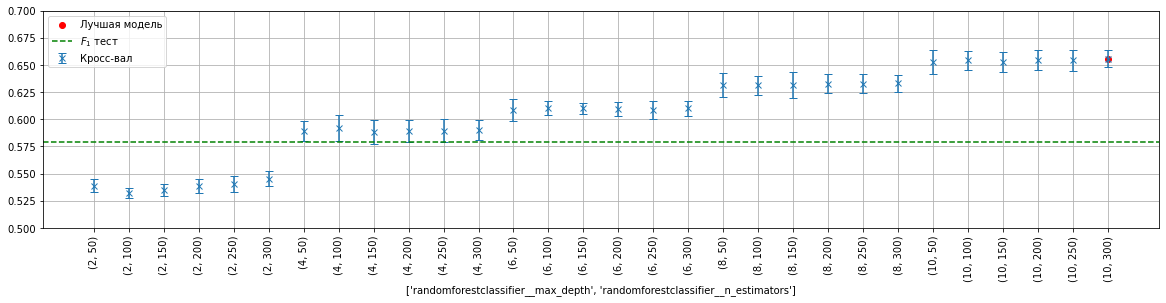

In [72]:
plt.figure(figsize=(20, 4))

plot_cv('cv_smote_randomforest', cv_path_dict, y_min=.5, y_max=.7)

## Использование Time-Series кросс-валидации

In [73]:
cv_path_dict_tss = create_path_dict(cv_path_tss, 'run_(.+)_cv_results')

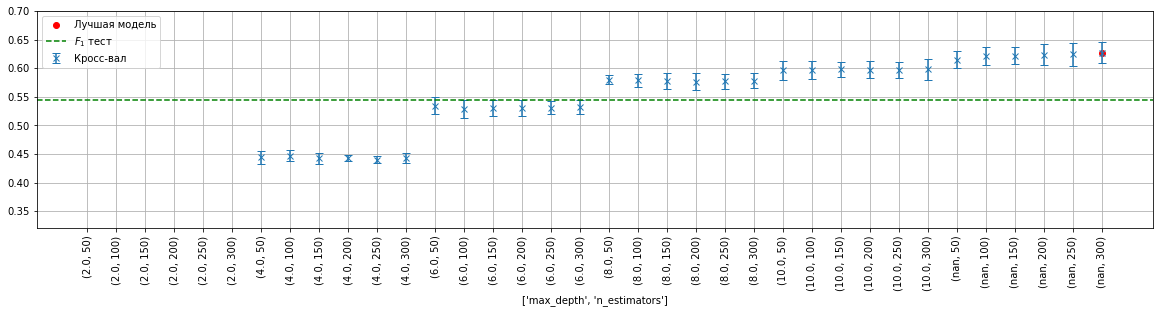

In [74]:
plt.figure(figsize=(20, 4))

plot_cv('cv_randomforest', cv_path_dict_tss, prefix='tss_', y_max=.7)

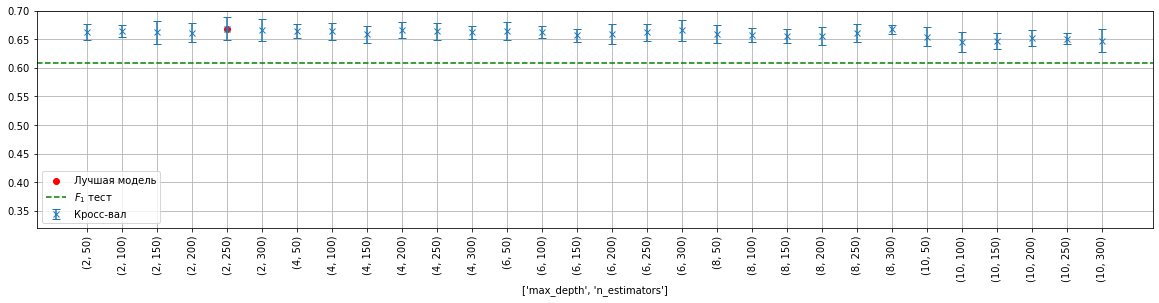

In [75]:
plt.figure(figsize=(20, 4))

plot_cv('cv_catboost', cv_path_dict_tss, prefix='tss_', y_max=.7)

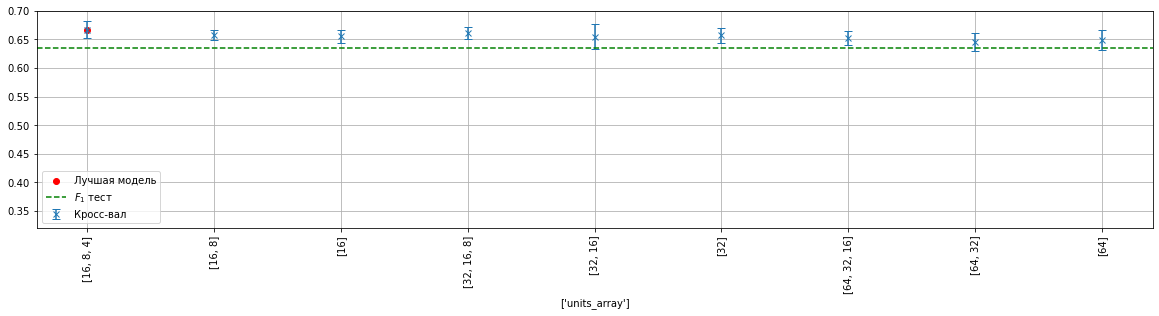

In [76]:
plt.figure(figsize=(20, 4))

plot_cv('cv_nn_perceptron', cv_path_dict_tss, prefix='tss_', y_max=.7)

In [77]:
# Неадекватные значения при маленьком тренировочного набора

cv1 = pd.read_csv(cv_path_dict['cv_ridge'], index_col=0)
cv1.loc[cv1.ridgeclassifier__alpha == 0.1]

,ridgeclassifier__alpha,score,split
0,0.1,0.449165,0
1,0.1,0.446298,1
2,0.1,0.444085,2
3,0.1,0.455822,3
4,0.1,0.441069,4


In [78]:
cv1 = pd.read_csv(cv_path_dict['cv_catboost'], index_col=0)
cv1.loc[(cv1.max_depth == 6) & (cv1.n_estimators == 100)].score

65    0.668819
66    0.658774
67    0.657615
68    0.653880
69    0.671521
Name: score, dtype: float64

In [79]:
cv1 = pd.read_csv(cv_path_dict['cv_catboost'], index_col=0)
cv1.loc[(cv1.max_depth == 2) & (cv1.n_estimators == 300)].score

25    0.681650
26    0.658584
27    0.647824
28    0.661780
29    0.677992
Name: score, dtype: float64

# Кривые обучения для перцептрона

In [80]:
history_dict = create_path_dict(history_path, key_regexp='run_(.*)_history')

(<Figure size 864x1152 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Горизонт 1'}>,
         <AxesSubplot:title={'center':'Горизонт 2'}>],
        [<AxesSubplot:title={'center':'Горизонт 3'}>,
         <AxesSubplot:title={'center':'Горизонт 4'}>],
        [<AxesSubplot:title={'center':'Горизонт 5'}>,
         <AxesSubplot:title={'center':'Горизонт 6'}>],
        [<AxesSubplot:title={'center':'Горизонт 7'}>,
         <AxesSubplot:title={'center':'Горизонт 8'}>]], dtype=object))

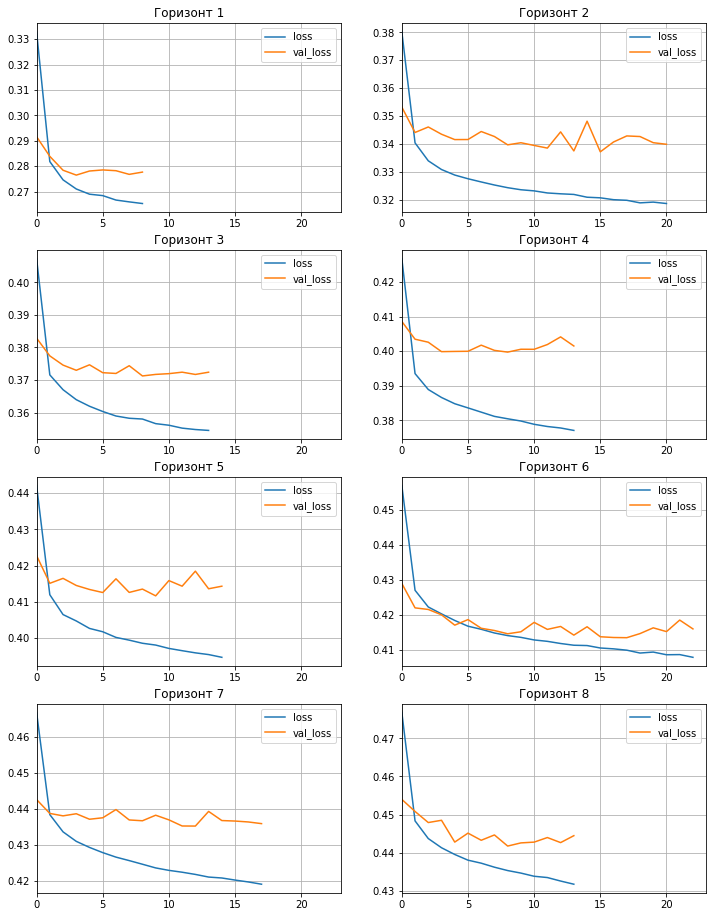

In [81]:
plot_history("cv_nn_perceptron", x_max=23)

(<Figure size 864x1152 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Горизонт 1'}>,
         <AxesSubplot:title={'center':'Горизонт 2'}>],
        [<AxesSubplot:title={'center':'Горизонт 3'}>,
         <AxesSubplot:title={'center':'Горизонт 4'}>],
        [<AxesSubplot:title={'center':'Горизонт 5'}>,
         <AxesSubplot:title={'center':'Горизонт 6'}>],
        [<AxesSubplot:title={'center':'Горизонт 7'}>,
         <AxesSubplot:title={'center':'Горизонт 8'}>]], dtype=object))

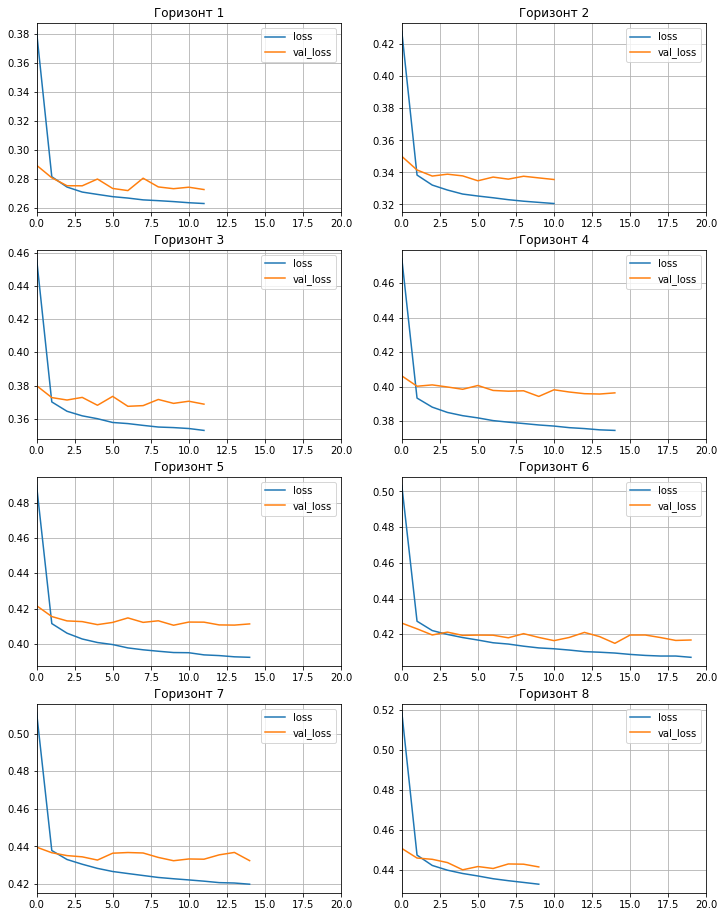

In [82]:
plot_history("nn_perceptron", x_max=20)

(<Figure size 864x1152 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Горизонт 1'}>,
         <AxesSubplot:title={'center':'Горизонт 2'}>],
        [<AxesSubplot:title={'center':'Горизонт 3'}>,
         <AxesSubplot:title={'center':'Горизонт 4'}>],
        [<AxesSubplot:title={'center':'Горизонт 5'}>,
         <AxesSubplot:title={'center':'Горизонт 6'}>],
        [<AxesSubplot:title={'center':'Горизонт 7'}>,
         <AxesSubplot:title={'center':'Горизонт 8'}>]], dtype=object))

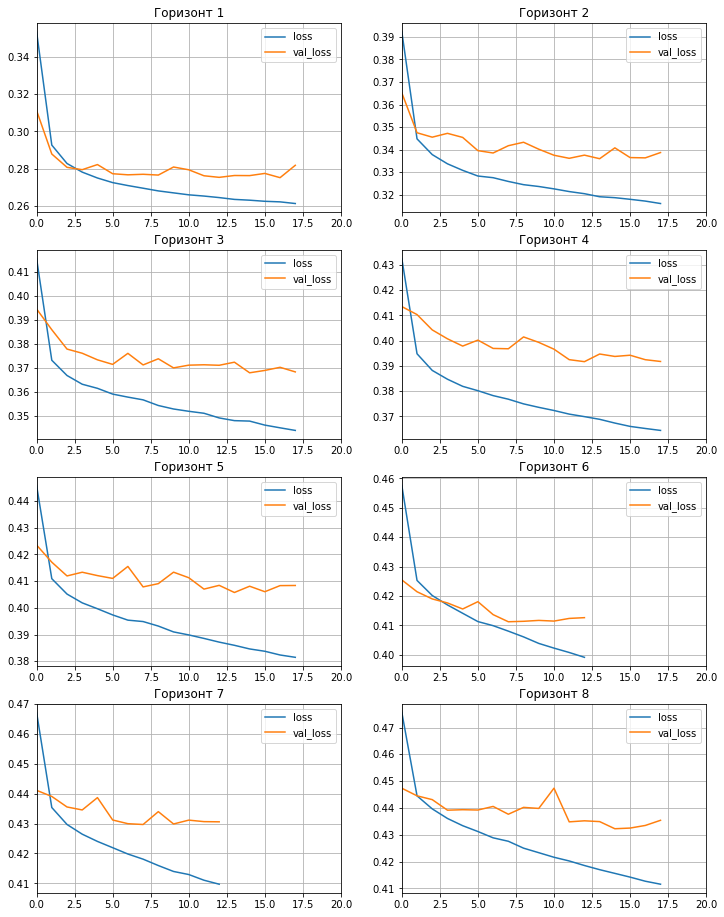

In [83]:
plot_history("nn_lstm", x_max=20)

(<Figure size 864x1152 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Горизонт 1'}>,
         <AxesSubplot:title={'center':'Горизонт 2'}>],
        [<AxesSubplot:title={'center':'Горизонт 3'}>,
         <AxesSubplot:title={'center':'Горизонт 4'}>],
        [<AxesSubplot:title={'center':'Горизонт 5'}>,
         <AxesSubplot:title={'center':'Горизонт 6'}>],
        [<AxesSubplot:title={'center':'Горизонт 7'}>,
         <AxesSubplot:title={'center':'Горизонт 8'}>]], dtype=object))

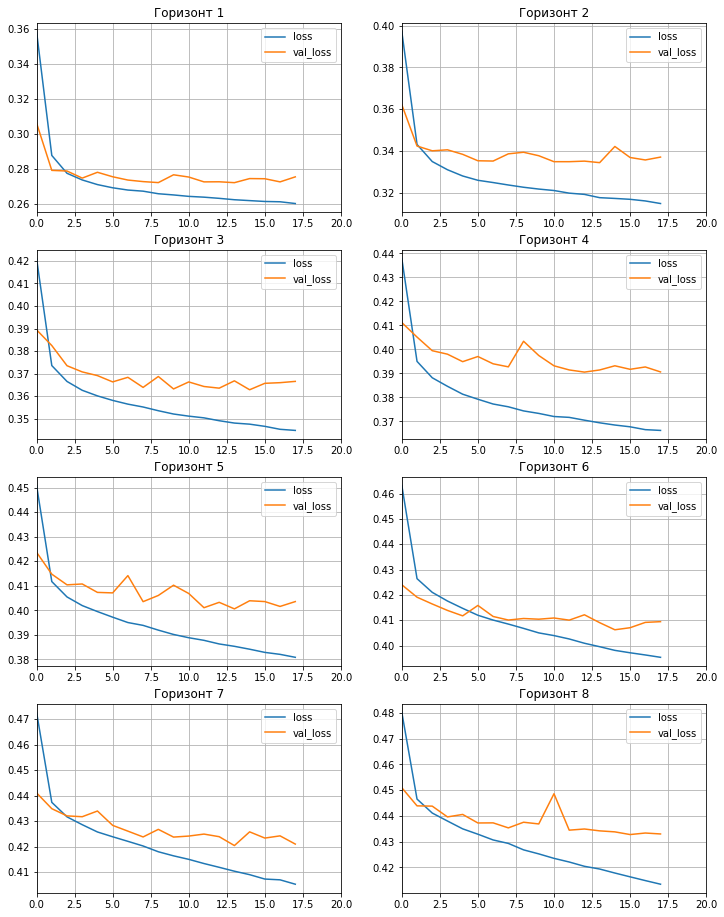

In [84]:
plot_history("nn_gru", x_max=20)

# Значимость признаков

In [85]:
fi_dict = create_path_dict(fi_path, 'feature_importances_run_(.+)', extension='.xlsx')

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

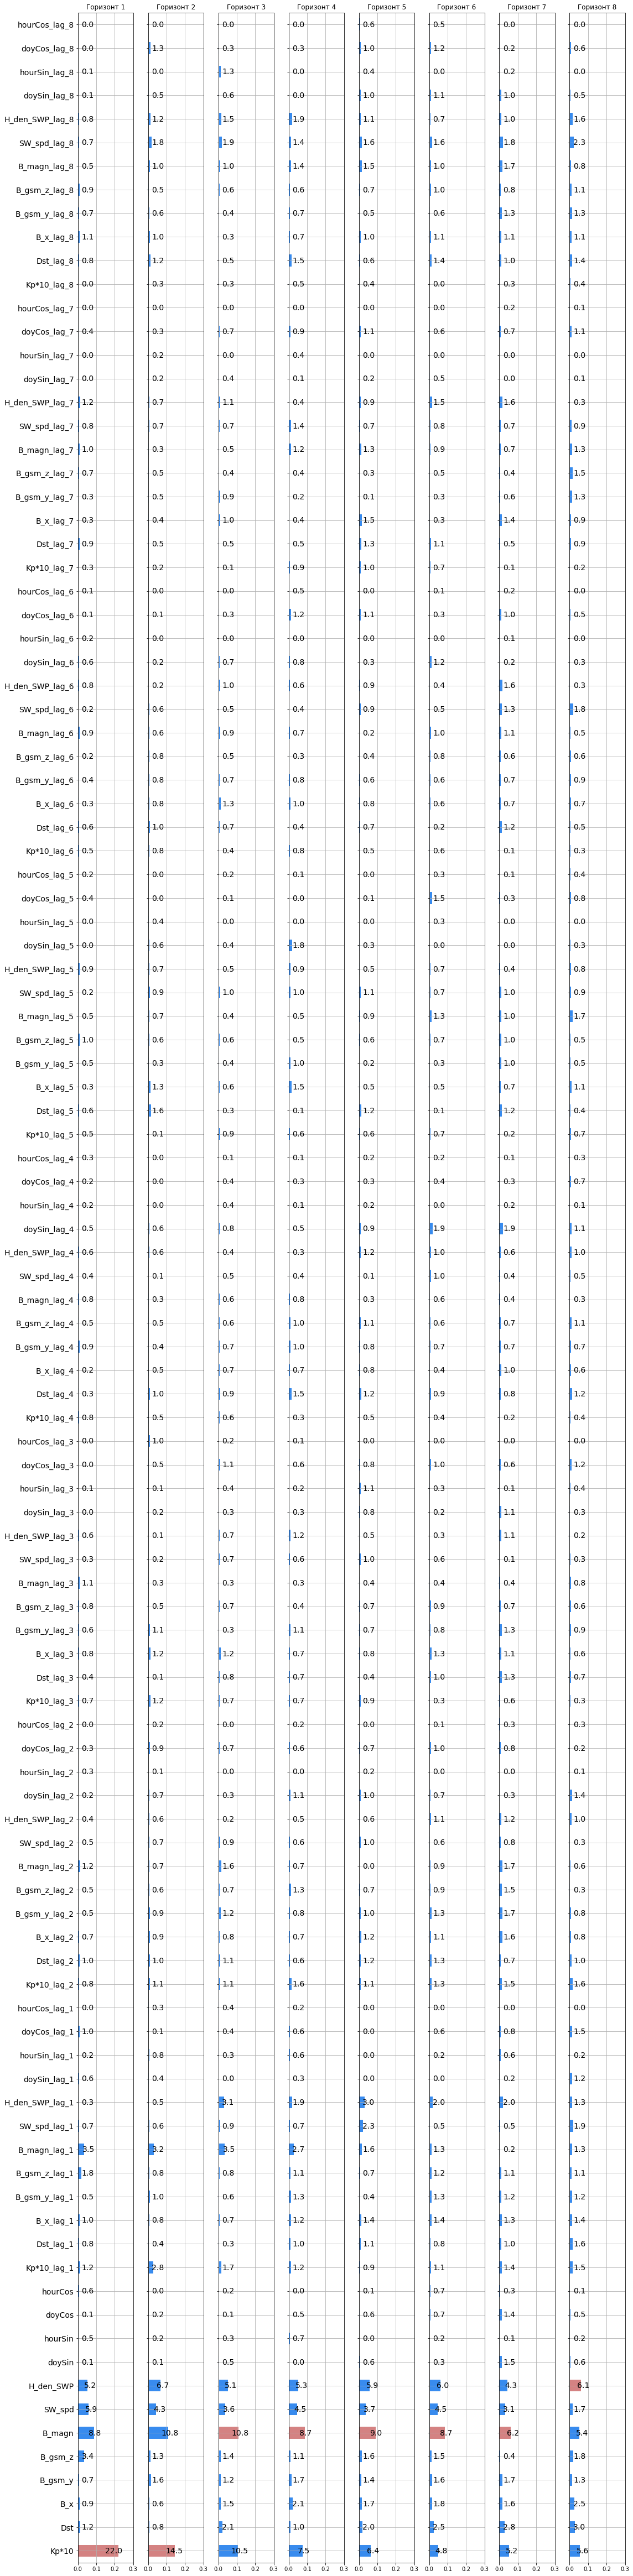

In [86]:
plot_fi('catboost', max_x=.30)

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

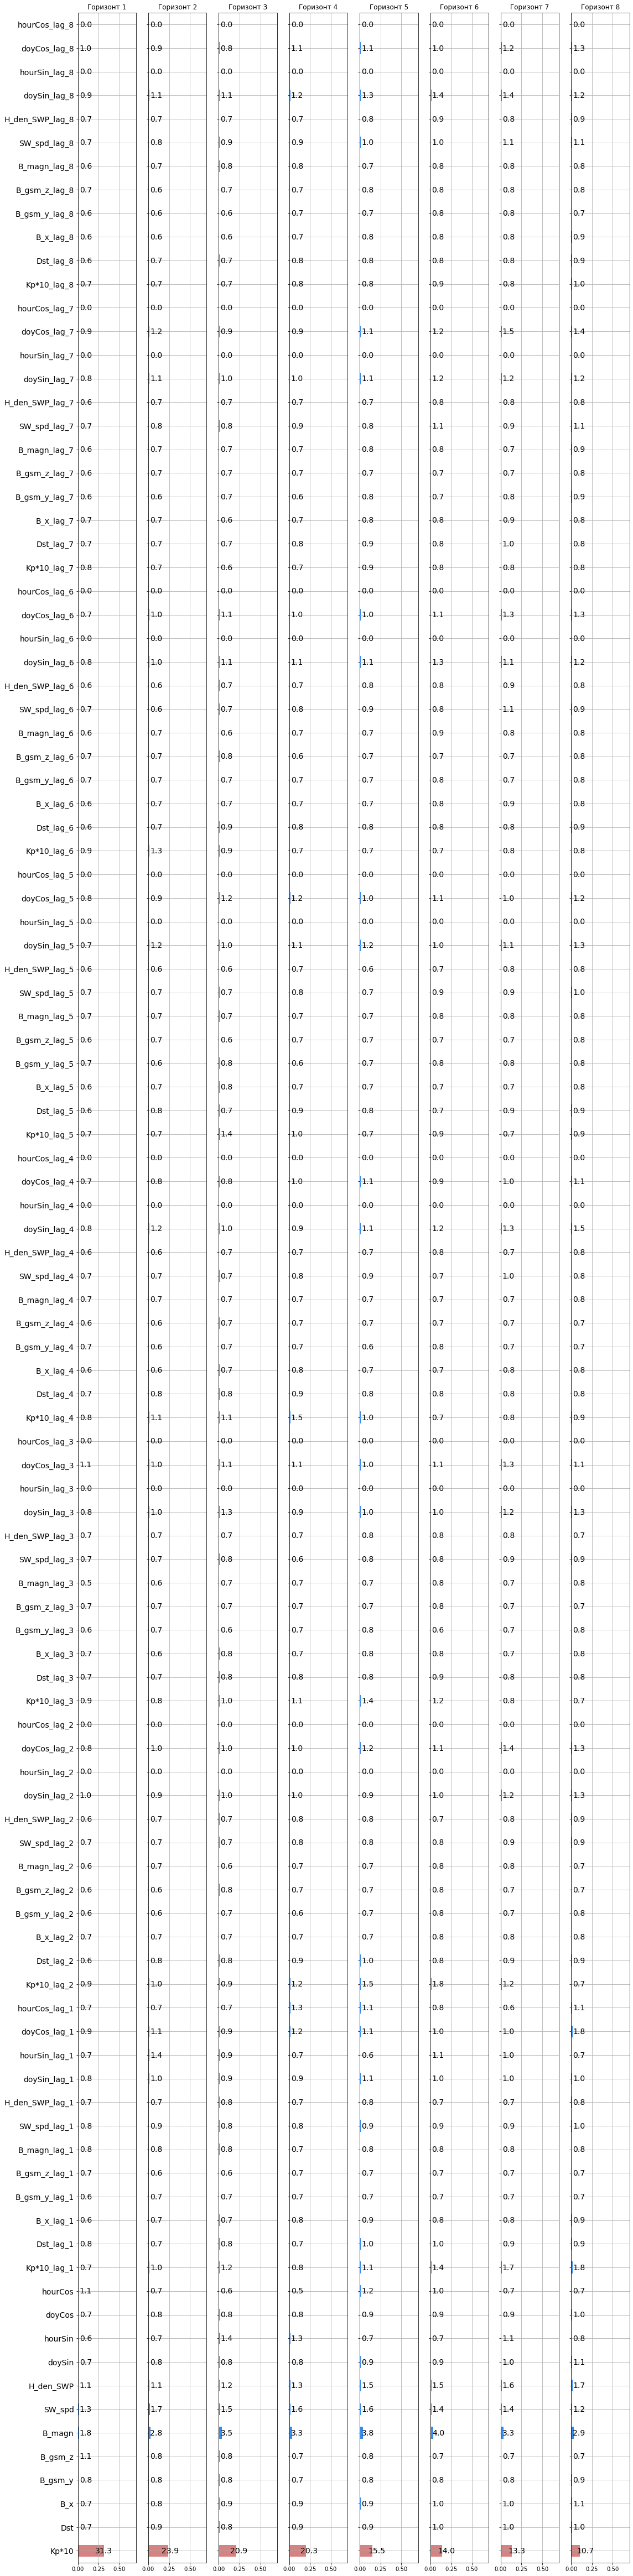

In [87]:
plot_fi('xgboost', max_x=.7)

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

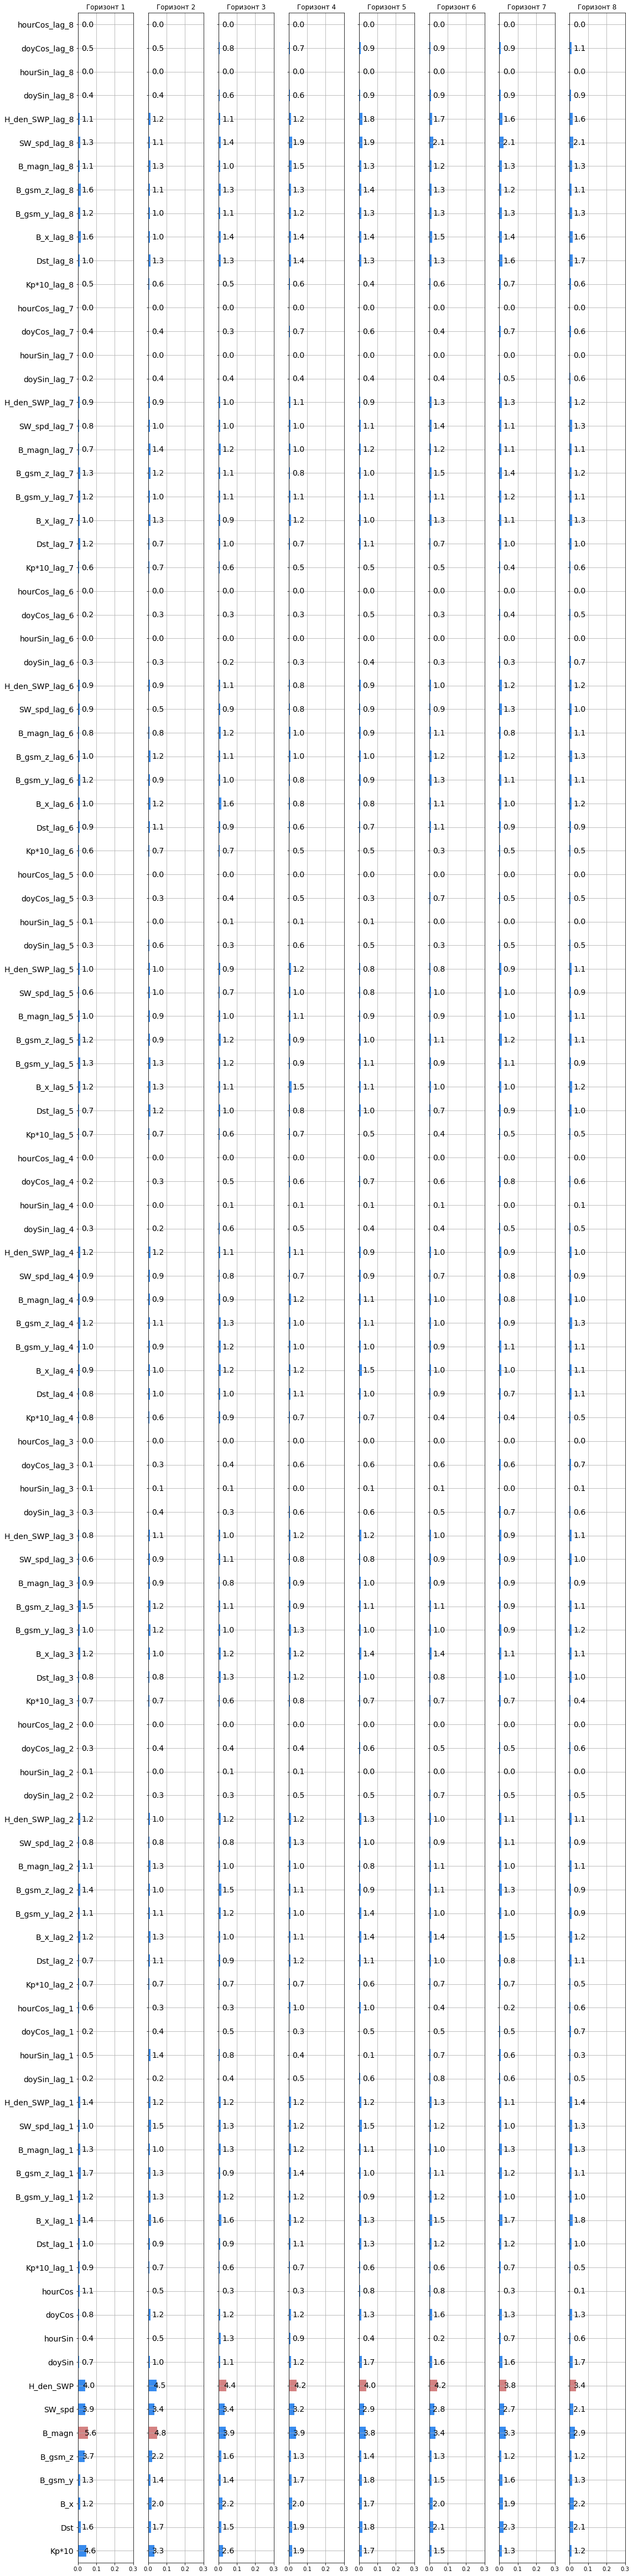

In [88]:
plot_fi('lightgbm', max_x=.3)

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

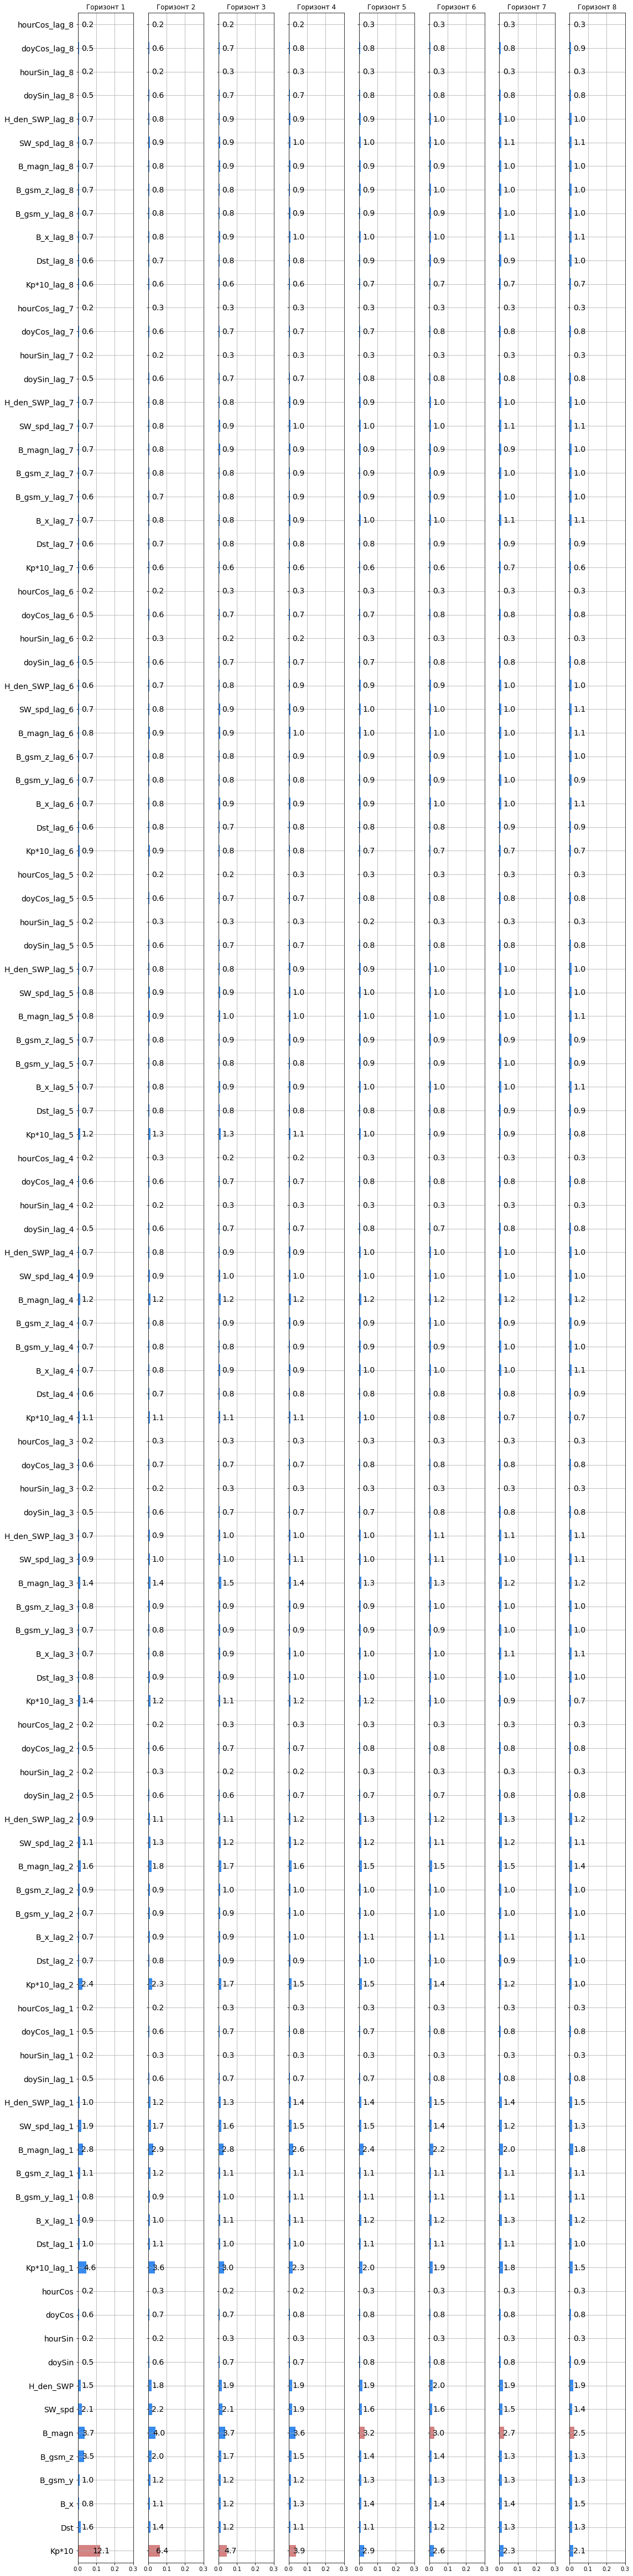

In [89]:
plot_fi('randomforest', max_x=.30)

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

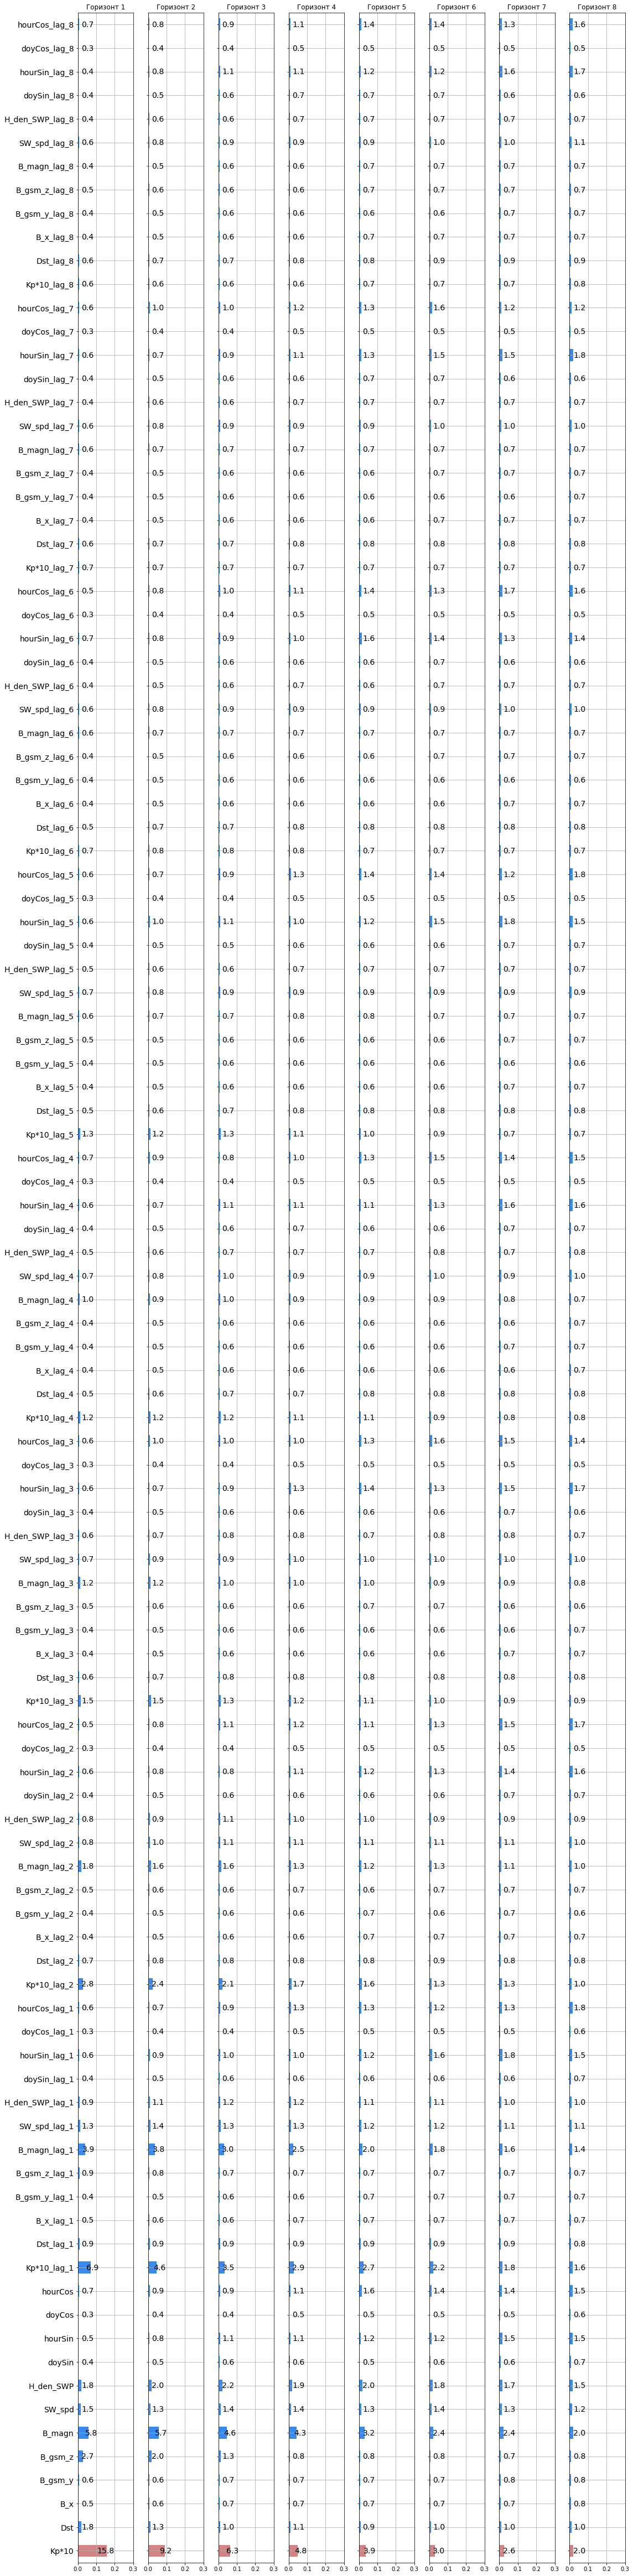

In [90]:
plot_fi('smote_randomforest', max_x=.30)

(<Figure size 1152x4665.6 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Горизонт 1'}>,
        <AxesSubplot:title={'center':'Горизонт 2'}>,
        <AxesSubplot:title={'center':'Горизонт 3'}>,
        <AxesSubplot:title={'center':'Горизонт 4'}>,
        <AxesSubplot:title={'center':'Горизонт 5'}>,
        <AxesSubplot:title={'center':'Горизонт 6'}>,
        <AxesSubplot:title={'center':'Горизонт 7'}>,
        <AxesSubplot:title={'center':'Горизонт 8'}>], dtype=object))

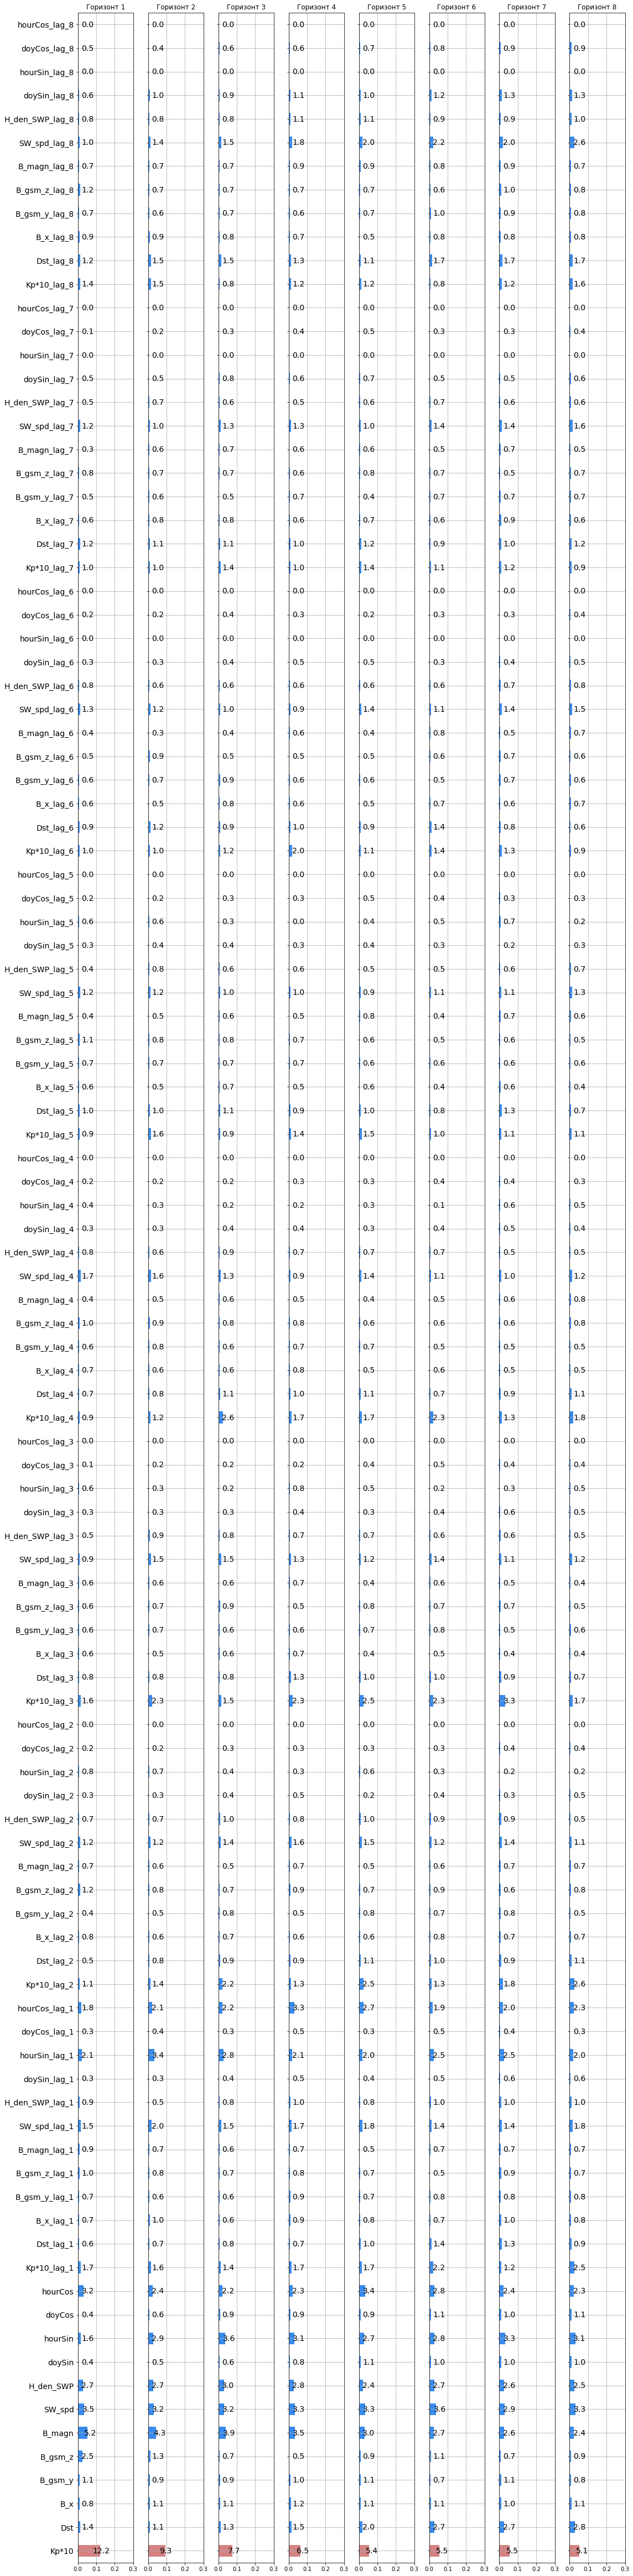

In [91]:
plot_fi('smote_lightgbm', max_x=.3)

In [59]:
report[report.index.str.contains('catboost')]

,0,1,2,3,4,5,6,7
tss_cv_catboost,0.608457,0.501424,0.378892,0.355753,0.345841,0.337811,0.336063,0.328674
cv_catboost,0.608457,0.501424,0.378892,0.355753,0.345841,0.337811,0.336063,0.328674
catboost,0.608223,0.529300,0.388277,0.372010,0.346721,0.342567,0.346086,0.334205
smote_catboost,0.583634,0.513995,0.393753,0.387569,0.360196,0.358416,0.344599,0.349110
